# Homework 3

## Task 1

Consider a following model: 

$ f(x_1, x_2) = (x_1 + x_2)^2 $

Assume that $ x_1, x_2 \sim U[-1,1] $ and $ x_1=x_2$ (full dependency)

Calculate PD profile for variable $x_1$ in this model.

Extra task if you do not fear conditional expected values: Calculate ME and ALE profiles for variable $x_1$ in this model.

$g^{PD}_j(z) = \mathbb{E}_{X_{-j}}[f(X_{j|=z})] = \mathbb{E}_{x_{2}}[(z + x_2)^2] = z^2 + 2z \cdot \mathbb{E}[x_2] + \mathbb{E}[x_2^2] = z^2 + \frac{1}{3}$

$g^{ME}_j(z) = \mathbb{E}_{x_{-j} | x_j= z}[f(X_{j|=z})] = \mathbb{E}_{x_{2} | x_1 = z}[(z + x_2)^2] = z^2 + 2z \cdot \mathbb{E}_{x_{2} | x_1 = z}[x_2] + \mathbb{E}_{x_{2} | x_1 = z}[x_2^2] = z^2 + 2z^2 + z^2 = 4z^2$

$g^{AL}_j(z)= \int ^z_{z_0}[E_{X_{−j|x_j=v}}\frac{\delta f(x)}{\delta x_j}]dv = \int ^z_{-1}[E_{X_{x_2|x_1=v}}\frac{\delta (x_1 + x_2)^2}{\delta x_1}]dv = \int ^z_{-1}[E_{X_{x_2|x_1=v}} 2x_1 + 2x_2]dv = \int ^z_{-1} 4v dv = 2z^2 - 2$

## Task 2

In [1]:
# imports
import xgboost as xgb
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from PyALE import ale

I’ll be using the Phoneme dataset, which has 5 numerical features and a binary target variable (1 or 2) representing two phoneme classes.

In [2]:
# read data
data = pd.read_csv("phoneme.csv")
X = data.drop(["Unnamed: 0", "TARGET"], axis = 1)
y = data["TARGET"].values

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)

# datasets and dataloaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train,dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
training_data = DataLoader(train_dataset, batch_size= 64, shuffle=True)
testing_data = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [3]:
display(X.head())

,V1,V2,V3,V4,V5
0,0.489927,-0.451528,-1.047990,-0.598693,-0.020418
1,-0.641265,0.109245,0.292130,-0.916804,0.240223
2,0.870593,-0.459862,0.578159,0.806634,0.835248
3,-0.628439,-0.316284,1.934295,-1.427099,-0.136583
4,-0.596399,0.015938,2.043206,-1.688448,-0.948127


In [4]:
model_xgb = xgb.XGBRegressor(objective = "reg:squarederror")
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

Minimum and Maximum of V1 in the dataset

In [5]:
max_val = X_test[:, 0].max()
min_val = X_test[:, 0].min()

print("max of x_test for variable 0: ", max_val)
print("min of x_test for variable 0: ", min_val)

max of x_test for variable 0:  3.438791
min of x_test for variable 0:  -2.169755


### Ceteris paribus for V1

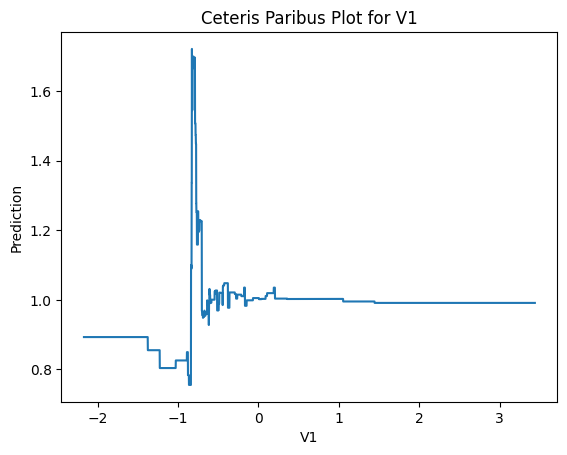

In [6]:
feature = "V1"
# Create a range of values for this feature
x_values = np.linspace(min_val, max_val, 10000)

# Create copies of the observation with different feature values
X_cp = pd.DataFrame([X.iloc[0].values] * len(x_values), columns=X.iloc[0].index)

X_cp[feature] = x_values

# Get predictions
y_pred = model_xgb.predict(X_cp)

plt.plot(x_values, y_pred)
plt.xlabel(feature)
plt.ylabel('Prediction')
plt.title(f'Ceteris Paribus Plot for {feature}')
plt.show()

*The plot shows how the model’s prediction changes as the value of V1 varies, while all other variables are kept constant. For most of the range, changes in V1 have only a small effect on the prediction — it stays roughly around 1. However, there is a sharp increase around V1 ≈ -1, where the prediction suddenly spikes from about 1.0 up to nearly 1.8 before dropping back down.*

*This suggests that the model is particularly sensitive to V1 values near -1, possibly because that region corresponds to a boundary or threshold the model has learned. Outside of that range, V1 does not strongly influence the output.*

### Partial dependence profiles for V1

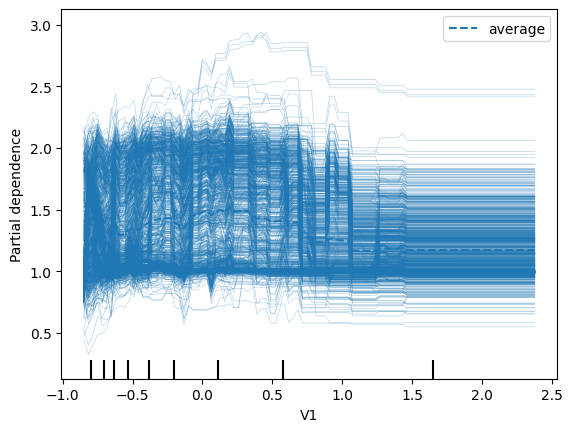

In [19]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(
    model_xgb, X, features=["V1"], kind="both"
)

*The feature V1 affects the prediction mainly in the region between -1 and 1, where the model’s sensitivity is the highest and predictions vary most across instances. Outside that range, the relationship stabilizes, indicating diminishing influence of V1.*

### My implementation of PDP

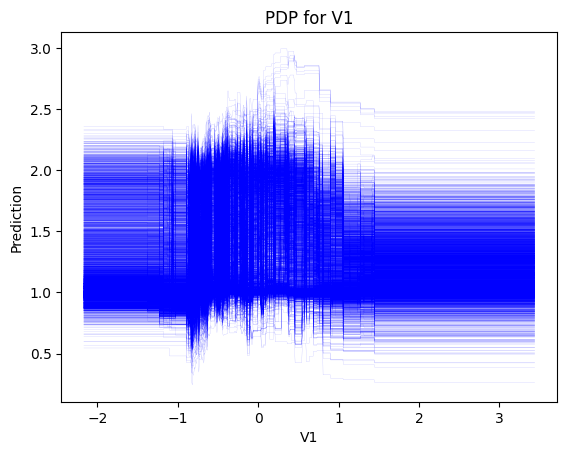

In [20]:
for i in range(len(X)):
    feature = "V1"
    # Create a range of values for this feature
    x_values = np.linspace(min_val, max_val, 1000)

    # Create copies of the observation with different feature values
    X_cp = pd.DataFrame([X.iloc[i].values] * len(x_values), columns=X.iloc[0].index)

    X_cp[feature] = x_values

    # Get predictions
    y_pred = model_xgb.predict(X_cp)

    plt.plot(x_values, y_pred, "b", linewidth=0.1, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Prediction')
    plt.title(f'PDP for {feature}')
plt.show()

*The resulting plot closely resembles the one generated by standard PDP implementations. The most influential range of the feature appears to be between -1 and 1, where the model’s predictions vary the most.*

### ALE for feature "V1"

PyALE._ALE_generic:INFO: Continuous feature detected.


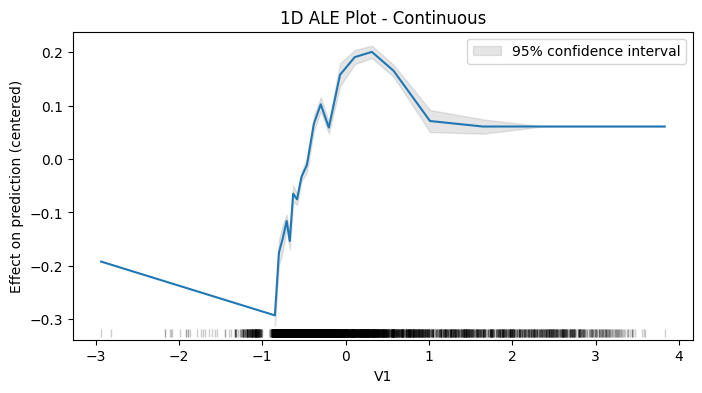

In [22]:
# Compute ALE for feature "V1"
ale_eff = ale(X=X, model=model_xgb, feature=["V1"])

*For V1 < -1, the ALE is negative: the model predicts lower values than average.*

*Between -1 and 1, the ALE rises sharply and peaks near 0, V1 strongly increases the prediction in this region.*

*After about V1 > 1, the curve flattens → V1 stops influencing the prediction much.*

*This means the model is most sensitive to V1 between -1 and 1, where the effect on the prediction changes most rapidly.*